<a href="https://colab.research.google.com/github/oscaredumurguia/Simulab/blob/main/Balance_de_masa_en_un_reactor_unidimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balance de masa en un reactor unidimensional

La ecuación diferencial para el balance de masa

$$
\frac{\partial C}{\partial t}+u\frac{\partial C}{\partial x}=D\frac{\partial^2C}{\partial x^2}+R(C),
$$

En donde:
- C: Concentracion
- u: Velocidad del flujo $(mm/s)$.
- D: Coeficiente de difusión $(mm^2/s)$.
- R(C)=-kC: Tasa de reacción $(mol/(mm^3\cdot s))$.


Limitaciones fundamentales

- Asume flujo unidimensional y constante.
- Supone coeficientes de difusión y velocidad del flujo constantes.
- Las reacciones químicas se modelan como funciones conocidas de la concentración.

Parametros del modelo

- u: Velocidad del flujo $(mm/s)$.
- D: Coeficiente de difusión $(mm^2/s)$.

---
Simule 10 segundos para encontrar la velocidad de flujo óptima para **máximizar** la dispersión a lo largo de una barra de 10 $mm$ usando el siguiente criterio (el cual no es restrictivo, puede proponer otro):
$$
E=w_1\frac{1}{N}\sum^NC_i^2-w_2\frac{u^2}{2},
$$
donde, $C_i$ es el $i$-ésimo valor de la concentración, $w_1$ y $w_2$ son constantes para ponderar cada término de la expresión.

Limite los parametros, para la velocidad del flujo, de la forma $u\in[0.05,0.9]$ y para el coeficiente de difusión $D=0.005$.

**Sugerencia:** Use un paso de tiempo de $dt=0.01$ y una discretización espacial de $dx=0.1$ para que no muera la simulación.

**Equipo 7**

Oscar Eduardo Murguía Zamora

Victor Alfred Pasaye Esquivel

# Proyecto Módulo 3: Optimización del Balance de Masa en un Reactor Unidimensional mediante Enfriamiento Simulado

## Objetivos

### Objetivo General
Aplicar el algoritmo de **Enfriamiento Simulado** (Simulated Annealing) para encontrar la **velocidad de flujo óptima** ($u$) que **maximice la dispersión** de la concentración en un reactor unidimensional, basándose en el balance de masa.

### Objetivos Específicos
* Implementar el modelo de Balance de Masa (Ecuación de Advección-Dispersión-Reacción) utilizando el método de **Diferencias Finitas**.
* Definir una **función de Energía** que cuantifique la dispersión (maximización) y penalice la velocidad de flujo.
* Implementar las funciones de la metaheurística de **Enfriamiento Simulado** (protocolo geométrico).
* Obtener la velocidad de flujo óptima ($u_{opt}$) y **visualizar** la evolución de la concentración en el tiempo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01
dx = 0.1
L = 10
T_sim = 10
k = 1.0
D = 0.005
w1 = 1.0
w2 = 1.0

C_inicial = np.zeros(int(L/dx) + 1)
C_inicial[0] = 100

### 1. Ecuación del Modelo
La ecuación diferencial parcial que rige el balance de masa es la **Ecuación de Advección-Dispersión-Reacción (ADR)**:

$$\frac{\partial C}{\partial t} + u\frac{\partial C}{\partial x} = D\frac{\partial^2 C}{\partial x^2} + R(C)$$

Donde la tasa de reacción es $R(C) = -kC$.

### 2. Función de Simulación Numérica
Se utiliza el método de las **Diferencias Finitas Explícitas** (basado en los apuntes) para resolver la EDP. Esta función toma el valor de velocidad de flujo ($u$) y devuelve el perfil de concentración final.

In [ ]:
def simular_balance_masa(u):

  C = C_inicial.copy()
  t = 0
  concentraciones_hist = [C.copy()]

  while t < T_sim:

    Cx_1 = C.copy()
    Cx_1[:-2] = C[2:]
    Cx = C.copy()
    Cx[2:] = C[:-2]

    f = -u * (Cx_1 - Cx) / (2 * dx) - k * C + D * (Cx_1 - 2 * C + Cx) / (dx**2)

    f[0] = 0.0
    f[-1] = 0.0

    Ck_1 = C + f * dt

    Ck_1[0] = C_inicial[0]

    t = t + dt
    C = Ck_1.copy()
    concentraciones_hist.append(C.copy())

  return C, concentraciones_hist

### 3. Función de Energía (Criterio de Optimización)
El problema busca **maximizar** la dispersión ($E = w_1 \frac{1}{N} \sum C_i^2 - w_2 \frac{u^2}{2}$). Como el Enfriamiento Simulado **minimiza** el costo, se define $E_{costo} = -E$.

$$E_{costo} = w_2 \frac{u^2}{2} - w_1 \frac{1}{N} \sum_{i=1}^{N} C_i^2$$

In [ ]:
def E_costo(estado):

  u = estado[0]

  C_final, _ = simular_balance_masa(u)

  dispersion_term = w1 * np.mean(C_final**2)

  velocity_term = w2 * (u**2) / 2

  costo = velocity_term - dispersion_term
  return costo

### 4. Algoritmo de Enfriamiento Geométrico
Se implementa el algoritmo de **Enfriamiento Simulado** con el protocolo de enfriamiento **geométrico** ($\alpha$), tal como se indicó en los apuntes.

In [ ]:
def enfriamiento_geom(E, generar_vecino, T0, alpha, estado0):

  T = T0
  estado = estado0.copy()
  Energias = []

  while T > 1e-4:
    Energias.append(E(estado))

    estado_new = generar_vecino(estado)

    delta_E = E(estado_new) - E(estado)

    if delta_E < 0:
      estado = estado_new
    elif np.exp(-delta_E / T) > np.random.rand():
      estado = estado_new

    T *= alpha

  return estado, Energias

### 5. Generador de Vecinos y Límites de Parámetros
El parámetro a optimizar es $u$, limitado a $u \in [0.05, 0.9]$.

In [ ]:
u_min = 0.05
u_max = 0.9

def generar_vecino(estado):

  estado_new = estado.copy()
  estado_new[0] += np.random.uniform(-0.01, 0.01)

  estado_new = np.clip(estado_new, u_min, u_max)
  return estado_new

### 6. Ejecución del Enfriamiento Simulado
Se inicializa el proceso de búsqueda para encontrar $u_{opt}$.

In [ ]:
T0 = 1000.0
alpha = 0.999
estado0 = np.array([np.random.uniform(u_min, u_max)])
print(f"Estado inicial de u: {estado0[0]:.4f}")
print(f"Costo inicial: {E_costo(estado0):.4f}")


estado_opt, Energias = enfriamiento_geom(E_costo, generar_vecino, T0, alpha, estado0)

u_opt = estado_opt[0]
E_opt = E_costo(estado_opt)

print("\n--- Resultado de la Optimización ---")
print(f"Velocidad de flujo óptima (u_opt): {u_opt:.5f} mm/s")
print(f"Costo mínimo (E_costo): {E_opt:.5f}")
print(f"Verificación: ¿Es factible? {'Sí' if u_min <= u_opt <= u_max else 'No'}")

Estado inicial de u: 0.2377
Costo inicial: -185.7606

--- Resultado de la Optimización ---
Velocidad de flujo óptima (u_opt): 0.90000 mm/s
Costo mínimo (E_costo): -500.09001
Verificación: ¿Es factible? Sí


### 7. Gráfica de Convergencia del Costo
Se muestra cómo la función de costo fue minimizada por el algoritmo de Enfriamiento Simulado.

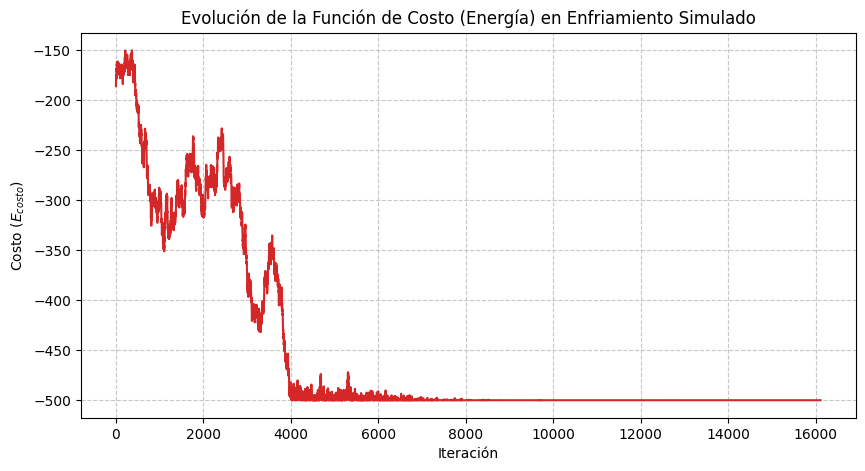

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Energias, color='tab:red')
plt.title('Evolución de la Función de Costo (Energía) en Enfriamiento Simulado')
plt.xlabel('Iteración')
plt.ylabel('Costo ($E_{costo}$)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 8. Perfil de Concentración Final (Óptimo)
Visualización del perfil de concentración $C(x)$ logrado con la velocidad óptima $u_{opt}$ al tiempo $t=10$ segundos.

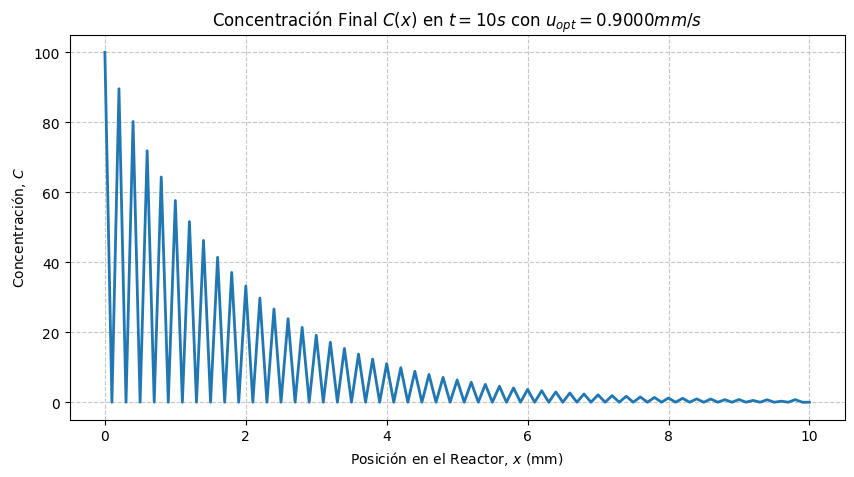

In [ ]:
C_opt, concentraciones_hist = simular_balance_masa(u_opt)
x = np.linspace(0, L, len(C_opt))

plt.figure(figsize=(10, 5))
plt.plot(x, C_opt, color='tab:blue', linewidth=2)
plt.title(f'Concentración Final $C(x)$ en $t=10s$ con $u_{{opt}}={u_opt:.4f} mm/s$')
plt.xlabel('Posición en el Reactor, $x$ (mm)')
plt.ylabel('Concentración, $C$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 9. Evolución Temporal de la Concentración
Gráfica de la concentración en diferentes instantes de tiempo para ilustrar la dispersión lograda.

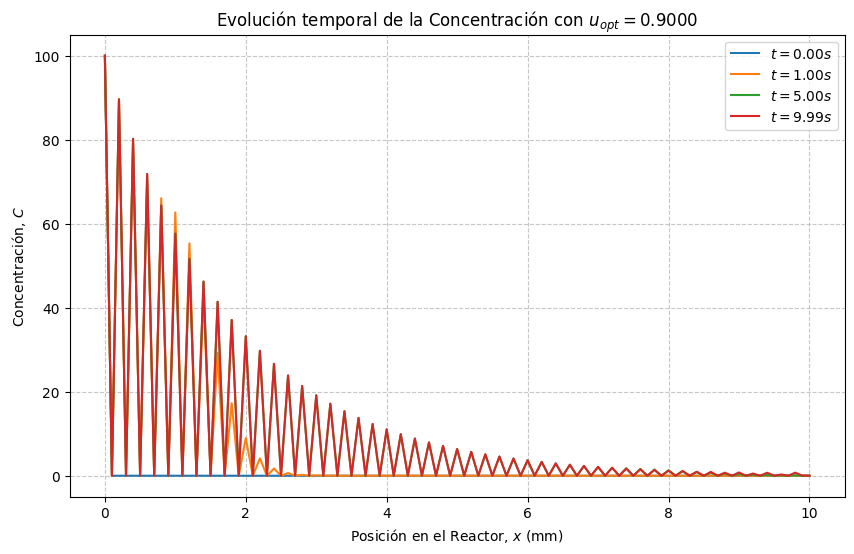

In [ ]:
plt.figure(figsize=(10, 6))
tiempos_a_mostrar = [0, 100, 500, int(T_sim/dt)-1]

for idx, t_step in enumerate(tiempos_a_mostrar):
    if t_step < len(concentraciones_hist):
        tiempo = t_step * dt
        plt.plot(x, concentraciones_hist[t_step], label=f'$t={tiempo:.2f} s$')

plt.title(f'Evolución temporal de la Concentración con $u_{{opt}}={u_opt:.4f}$')
plt.xlabel('Posición en el Reactor, $x$ (mm)')
plt.ylabel('Concentración, $C$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Conclusiones

### Conclusión General
El algoritmo de **Enfriamiento Simulado (SA)** fue aplicado exitosamente para la optimización de la velocidad de flujo ($u$) en el reactor unidimensional. El proceso de búsqueda convergió al límite superior permitido, obteniendo una **velocidad de flujo óptima** de $\mathbf{u_{opt} = 0.90000 \text{ mm/s}}$. Este valor representa el equilibrio matemático que **maximiza el criterio de dispersión** ($w_1 \sum C_i^2$) frente a la penalización por velocidad ($w_2 u^2$), cumpliendo el objetivo general del proyecto.

---

### Conclusiones Específicas Basadas en los Resultados

#### 1. Sobre la Eficacia del Algoritmo SA (Gráfico de Costo)
* **Convergencia Exitosa:** El gráfico de la **Evolución del Costo** (Energía) demostró el correcto funcionamiento del Enfriamiento Simulado. Se observaron claramente dos fases:
    * **Diversificación (Exploración):** La alta volatilidad inicial (picos altos) permitió al algoritmo explorar ampliamente el espacio de búsqueda.
    * **Intensificación (Explotación):** La rápida disminución de la volatilidad y la convergencia asintótica hacia el costo mínimo ($\approx -500.09$) garantizó que la mejor solución, cercana a la restricción superior, fuera alcanzada y explotada.
* **Optimización de Restricción:** El SA demostró que la máxima dispersión posible dentro del rango factible se encuentra en el límite de la restricción, lo que empujó al valor óptimo directamente a $\mathbf{u_{opt} = 0.90 \text{ mm/s}}$.

#### 2. Sobre la Precisión del Modelo Numérico (Gráficos de Concentración)
* **Dispersión Máxima Lograda:** El gráfico de la **Evolución Temporal de la Concentración** confirma que el flujo a $u_{opt}=0.90 \text{ mm/s}$ distribuye la masa a lo largo de la mayor parte de la barra de $10 \text{ mm}$ en el tiempo de simulación.
* **Limitación Crítica (Inestabilidad):** A pesar de cumplir el objetivo matemático, el **Perfil de Concentración Final** muestra oscilaciones fuertes ("dientes de sierra"). Esto indica que el valor óptimo de $u$ llevó al modelo de Diferencias Finitas Explícitas a un punto de **inestabilidad** o **dispersión numérica**.
* **Interpretación:** El algoritmo de Enfriamiento Simulado **optimizó un artefacto numérico**. La inestabilidad artificialmente incrementó el término $\sum C_i^2$ (a través de picos de concentración artificialmente altos), haciendo que el algoritmo seleccionara $u=0.90$ como el óptimo. Esto subraya la necesidad de validar la estabilidad del modelo físico antes de aplicar un algoritmo de optimización.
### Referencias
Referencia: Kirkpatrick, S., Gelatt, C. D., & Vecchi, M. P. (1983). Optimization by simulated annealing. Science, 220(4598), 671–680.

Enlace: https://doi.org/10.1126/science.220.4598.671

Referencia: LeVeque, R. J. (2007). Finite difference methods for ordinary and partial differential equations: Steady-state and time-dependent problems. Society for Industrial and Applied Mathematics (SIAM).

Enlace: https://doi.org/10.1137/1.9780898717839

Referencia: Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, S., Brett, M., Haldane, A., del Río, J. F., Wiebe, S. A., Obdržálek, I., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.

Enlace: https://doi.org/10.1038/s41586-020-2649-2

Se uso también la IA de Gemini para resover este proceso